# Rotina de Processamento dos Dados de CTD

### Importando Bibliotecas Utilizadas

In [51]:
# Importa bibliotecas para manipulação de dados tabulares
import pandas as pd  # Para manipulação de dados tabulares
import numpy as np  # Para operações numéricas eficientes
import seawater as sw  # Para cálculos relacionados à água do mar

# Importa bibliotecas para manipulação de expressões regulares
import re

# Importa bibliotecas para manipulação de datas e horas
import datetime  # Para manipulação de datas e horas
import pytz  # Para manipulação de fusos horários
from tzlocal import get_localzone  # Para obter o fuso horário local

# Importa bibliotecas para visualização de dados
import matplotlib.pyplot as plt  # Para visualização de dados em gráficos
import plotly.express as px  # Para visualização interativa de dados
import plotly.graph_objects as go  # Para criação de gráficos interativos
from plotly.subplots import make_subplots  # Para criar subplots em gráficos do Plotly
import dash  # Para construção de dashboards interativos
from dash import dcc, html  # Componentes para construção de interfaces gráficas com Dash
from dash.dependencies import Input, Output  # Para definir inputs e outputs em Dash
import plotly.io as pio  # Importa o módulo plotly.io com o nome abreviado pio

# Importa bibliotecas para manipulação de dados geoespaciais
import geopandas as gpd  # Para manipulação de dados geoespaciais
from shapely.geometry import Point, LineString  # Para representação de geometrias geoespaciais
from rasterio.plot import show  # Para exibição de imagens raster
import rasterio  # Para manipulação de dados raster

# Importa bibliotecas para interpolação de dados
from scipy.interpolate import griddata  # Para interpolação de dados em grade
import scipy.interpolate as si

# Importa bibliotecas para widgets interativos
import ipywidgets as widgets  # Para criação de widgets interativos
from IPython.display import display, HTML, clear_output  # Para exibir widgets e HTML no notebook

### Defindo o Caminho dos Arquivos 

In [49]:
basemap_path = '/home/ppms/Documents/TCC_Organizado/jp_notes_mb/dados/basemap_cNautica.tif'  # Caminho para o arquivo de mapa base

GPXfile = '/home/ppms/Documents/TCC_Organizado/jp_notes_mb/dados/GPS_20210227.gpx'  # Caminho para o arquivo GPX contendo dados de GPS

CTDfile = '/home/ppms/Documents/TCC_Organizado/jp_notes_mb/dados/202102270755_ASTD152-ALC-R02_0237_075509.Csv'  # Caminho para o arquivo CSV contendo dados de CTD

### Lendo e Organizando os Dados de GPS do arquivo GPX

In [3]:
def processar_arquivo_gpx(GPXfile, tz='America/Sao_Paulo', remover_linhas=0):
    """
    Função para processar um arquivo GPX, incluindo a leitura, extração de dados, filtragem e ajuste do DataFrame.

    Parâmetros:
    GPXfile (str): O caminho do arquivo GPX a ser processado.
    tz (str): O fuso horário desejado para conversão (padrão é 'America/Sao_Paulo').
    remover_linhas (int): O número de linhas a serem removidas do início do DataFrame (padrão é 0).

    Retorna:
    DataFrame: Um DataFrame contendo os dados GPS processados.
    """
    # Abrir e ler o conteúdo do arquivo GPX
    with open(GPXfile, 'r') as f:
        data = f.read()
    
    # Extrair latitudes, longitudes e tempo do arquivo GPX
    lat = np.array(re.findall(r'lat="([^"]+)', data), dtype=float)  # Extrair latitudes
    lon = np.array(re.findall(r'lon="([^"]+)', data), dtype=float)  # Extrair longitudes
    time = re.findall(r'<time>([^\<]+)', data)                      # Extrair tempo
    tempo = [datetime.datetime.strptime(t, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=datetime.timezone.utc) for t in time]
    
    # Filtrar latitudes e longitudes pela área de interesse
    LAT = lat[lat < -32]  # Filtrar latitudes
    LON = lon[lon < -52]  # Filtrar longitudes
    
    # Juntar as coordenadas com o tempo em um DataFrame
    df = pd.DataFrame({'lat': LAT, 'lon': LON, 'tempo': tempo})
    
    # Remover dados do dia 25/02/2021
    df = df[df['tempo'].dt.date != datetime.date(2021, 2, 25)]
    
    # Converter o fuso horário de UTC para Local
    tz_local = pytz.timezone(tz)
    df['tempo'] = df['tempo'].dt.tz_convert(tz_local)
    
    # Remover as primeiras linhas indesejadas
    df.drop(range(remover_linhas), inplace=True)
    
    # Resetar o índice
    df.reset_index(drop=True, inplace=True)
    
    return df


# Chamar a função processar_arquivo_gpx para processar o arquivo GPX
GPS_df = processar_arquivo_gpx(GPXfile, remover_linhas=1)

# Visualização dos primeiros registros do DataFrame
print("\nDados GPS:")
display(GPS_df.head())



Dados GPS:


lat        lon                     tempo
0 -32.136324 -52.102307 2021-02-26 07:54:17-03:00
1 -32.136302 -52.102142 2021-02-26 07:54:22-03:00
2 -32.136332 -52.102094 2021-02-26 07:54:28-03:00
3 -32.136321 -52.101962 2021-02-26 07:54:33-03:00
4 -32.136319 -52.101864 2021-02-26 07:54:38-03:00

### Visualizando os dados de GPS

In [4]:
# Função para atualizar o gráfico com base no intervalo selecionado
def update_map(start_datetime, end_datetime):
    filtered_df = GPS_df[(GPS_df['tempo'] >= start_datetime) & (GPS_df['tempo'] <= end_datetime)]
    fig = px.scatter_mapbox(filtered_df, lat='lat', lon='lon', color=filtered_df.tempo.dt.date, zoom=15, title='Dados de GPS: Selecione o intervalo de tempo')
    fig.update_layout(mapbox_style="open-street-map", margin={"r":20,"t":30,"l":20,"b":20})
    fig.show()

# Controle de intervalo para selecionar datas
start_date = widgets.DatePicker(description='Start Date', value=GPS_df['tempo'].min())
end_date = widgets.DatePicker(description='End Date', value=GPS_df['tempo'].max())

# Controle para selecionar a hora
start_time = widgets.IntSlider(description='Start Hour', min=0, max=23, value=0)
end_time = widgets.IntSlider(description='End Hour', min=0, max=23, value=0)

# Chamando a função update_map quando os valores dos controles mudarem
interactive_plot = widgets.interactive(update_map, 
                               start_datetime=widgets.DatetimePicker(description='Início:', value=GPS_df['tempo'].min()),
                               end_datetime=widgets.DatetimePicker(description='Fim:', value=GPS_df['tempo'].max()))
interactive_plot

interactive(children=(DatetimePicker(value=Timestamp('2021-02-26 07:54:17-0300', tz='America/Sao_Paulo'), desc…

In [5]:
# min_date = GPS_df['tempo'].min()
# max_date = GPS_df['tempo'].max()


# # Criando uma coluna de dias
# GPS_df['dia'] = GPS_df['tempo'].dt.date
# # Criando uma coluna para horas
# GPS_df['horas'] = GPS_df['tempo'].dt.time

# # Obtendo o timezone dos dados de GPS_df['tempo']
# timezone_gps = GPS_df['tempo'].dt.tz

# external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

# app = dash.Dash(__name__, external_stylesheets=external_stylesheets)
# app.layout = html.Div([
#     dcc.RangeSlider(
#         id='my-range-slider',
#         step=None,  # Deixar o step como None para que o slider possa selecionar datas específicas
#         marks={date.timestamp(): str(date) for date in pd.date_range(min_date, max_date, freq='T')},  # Marcas de data e hora, freq. minutos
#         value=[min_date.timestamp(), max_date.timestamp()]  # Valor padrão: intervalo de datas completo
#     ),
#     html.Div(id='output-container-range-slider', style={'color': 'white'}),  # Estilo adicionado para alterar a cor do texto para branco
#     dcc.Graph(id='gps-map')  # Adicionando um elemento dcc.Graph para mostrar o mapa
# ])

# @app.callback(
#     [Output('output-container-range-slider', 'children'),
#      Output('gps-map', 'figure')],
#     [Input('my-range-slider', 'value')]
# )
# def update_output(selected_timestamps):
#     # Convertendo os timestamps usando o mesmo timezone
#     selected_dates = [
#         pd.to_datetime(selected_timestamps[0], unit='s').tz_localize('UTC').tz_convert(timezone_gps), 
#         pd.to_datetime(selected_timestamps[1], unit='s').tz_localize('UTC').tz_convert(timezone_gps)
#     ]
#     filtered_df = GPS_df[(GPS_df['tempo'] >= selected_dates[0]) & (GPS_df['tempo'] <= selected_dates[1])]
    
#     fig = px.scatter_mapbox(filtered_df, lon='lon', lat='lat', color='dia', 
#                             hover_name='horas', zoom=14, )  
#     fig.update_layout(
#         title='Coordenadas do GPS',
#         #xaxis_title='Longitude',
#         #yaxis_title='Latitude',
#         mapbox_style="open-street-map",
#         autosize=True,
#         height=600
#     )
    
#     # fig.update_xaxes(showspikes=True, spikecolor="black", spikethickness=2)
#     # fig.update_yaxes(showspikes=True, spikecolor="black", spikethickness=2)
    
#     return f'Você selecionou o intervalo de datas: {selected_dates[0]} a {selected_dates[1]}', fig

# if __name__ == '__main__':
#     app.run(debug=True)

In [6]:
del GPXfile, processar_arquivo_gpx

### Leitura do arquivo CSV e processamento inicial dos dados de CTD

In [52]:
def processar_dados_csv(CTDfile):
    # Definir a string que indica o início dos dados
    string_inicio_dados = '[Item]\n'

    # Ler o arquivo CSV como uma lista de strings
    with open(CTDfile, 'r') as f:
        linhas = f.readlines()

    # Encontrar o índice da linha que contém a string de início dos dados
    indice_inicio_dados = linhas.index(string_inicio_dados)

    # Nomes originais das colunas
    col_nomes_orig = linhas[indice_inicio_dados+1]

    # Novos nomes das colunas
    col = ['tempo','pressao', 'temperatura', 'salinidade', 'condutividade', 'ec', 'densidade', 
         'sigmat', 'chlflu', 'chla', 'turbidez', 'do%', 'domgl', 'dommoll', 'bateria']

    # Ler o arquivo CSV e definir os novos nomes das colunas
    ctd_df = pd.read_csv(CTDfile, header=indice_inicio_dados+1, sep=',', index_col=False, names=col)

    # Ajuste do tipo de dados da coluna 'Datetime'
    ctd_df['tempo'] = pd.to_datetime(ctd_df['tempo'])
    
    # Definir o fuso horário desejado
    tz_default = pytz.timezone('America/Sao_Paulo')
    timezones = pytz.all_timezones
    
    tz_desejado_dropdown = widgets.Dropdown(options=timezones, value=tz_default.zone, description='Fuso Horário:')
    
    def atualizar_fuso_horario(tz_desejado):
        tz_desejado = pytz.timezone(tz_desejado)
        
        # Verificar se os valores já estão cientes do fuso horário
        if ctd_df['tempo'].dt.tz is None:
            ctd_df['tempo'] = ctd_df['tempo'].dt.tz_localize(tz=tz_desejado)
        else:
            ctd_df['tempo'] = ctd_df['tempo'].dt.tz_convert(tz=tz_desejado)
        
        print("Fuso horário atualizado para:", tz_desejado)

    
    # Exibir o dropdown para seleção do fuso horário
    interact_output = widgets.interactive_output(atualizar_fuso_horario, {'tz_desejado': tz_desejado_dropdown})
    display(tz_desejado_dropdown, interact_output)


    padrao = ['tempo','pressao', 'temperatura', 'salinidade', 'turbidez']
    
    # Criar os checkboxes
    checkboxes = [widgets.Checkbox(description=opcao, value=opcao in padrao) for opcao in col]

    # Número de colunas desejado
    num_colunas = round(len(col)/4)
    
    # Calcular o número de linhas necessário
    num_linhas = -(-len(col) // num_colunas)  # Ceil division
    
    # Criar uma grade para organizar os checkboxes em duas colunas
    w = widgets.GridBox(checkboxes, layout=widgets.Layout(grid_template_columns=f"repeat({num_colunas}, 200px)"))
    
    
    print("Selecione os parâmetros que serão utilizados:")
    # Mostrar os checkboxes em duas colunas
    display(w)

    check = widgets.ToggleButton(
            value=False,
            description='Selecionar',
            disabled=False,
            button_style='info', # 'success', 'info', 'warning', 'danger' or ''
            tooltip='Clique para salvar a seleção das colunas',
            icon='check' # (FontAwesome names without the `fa-` prefix)
    )    
    display(check)
    
    def fechar_grid(change):
        if change['new']:
            w.close()
            check.close()
            tz_desejado_dropdown.close()
    
    # Adicione um observador para o valor do botão de alternância
    check.observe(fechar_grid, names='value')

    colunas_selecionadas = []
    for idx, chkbx in enumerate(checkboxes):
        if chkbx.value == True:
            colunas_selecionadas.append(col[idx])
    
    
    # Mantendo apenas as colunas selecionadas
    ctd_df = ctd_df.loc[:, colunas_selecionadas]


    return ctd_df


CTD_df = processar_dados_csv(CTDfile)

Dropdown(description='Fuso Horário:', index=199, options=('Africa/Abidjan', 'Africa/Accra', 'Africa/Addis_Abab…

Output()

Selecione os parâmetros que serão utilizados:


GridBox(children=(Checkbox(value=True, description='tempo'), Checkbox(value=True, description='pressao'), Chec…

ToggleButton(value=False, button_style='info', description='Selecionar', icon='check', tooltip='Clique para sa…

In [8]:
del CTDfile, get_localzone, processar_dados_csv, pytz

In [9]:
display(CTD_df.head())

tempo  pressao  temperatura  salinidade  turbidez
0 2021-02-27 07:55:15-03:00   -1.245       24.985       0.015      1.57
1 2021-02-27 07:55:15-03:00   -1.245       24.990       0.015      1.46
2 2021-02-27 07:55:15-03:00   -1.245       24.990       0.015      2.37
3 2021-02-27 07:55:15-03:00   -1.245       24.989       0.015      3.13
4 2021-02-27 07:55:15-03:00   -1.245       24.984       0.015      3.08

### Visualizando os perfis verticais

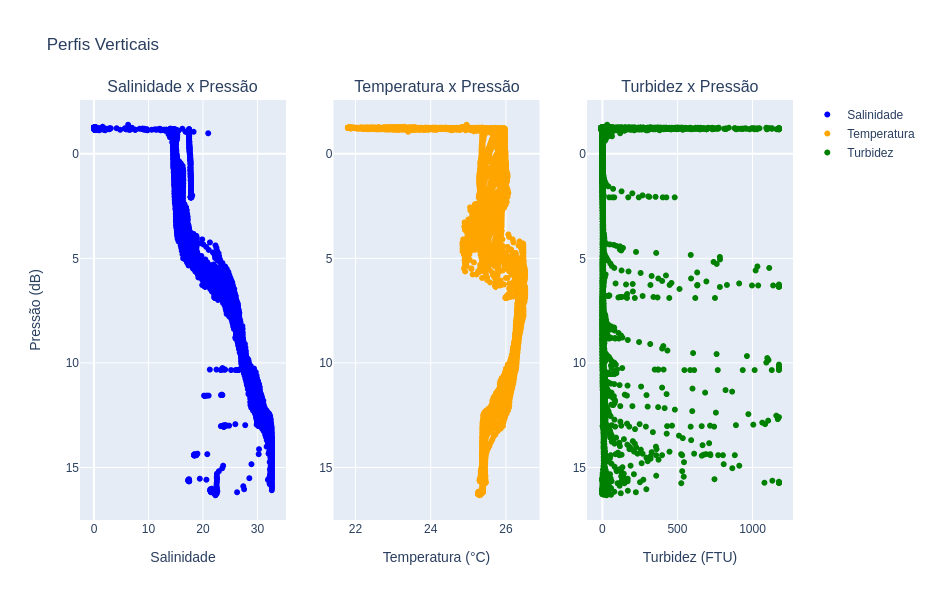

In [10]:
# Criar subplots
fig = make_subplots(rows=1, cols=3, shared_yaxes=True, subplot_titles=('Salinidade x Pressão', 'Temperatura x Pressão', 'Turbidez x Pressão'))

# Adicionar perfil de salinidade x pressão
fig.add_trace(go.Scatter(x=CTD_df['salinidade'], y=CTD_df['pressao'], mode='markers', name='Salinidade',
                         line=dict(color='blue')), row=1, col=1)
fig.update_xaxes(title_text="Salinidade", row=1, col=1)
fig.update_yaxes(title_text="Pressão (dB)", autorange="reversed", row=1, col=1)

# Adicionar perfil de temperatura x pressão
fig.add_trace(go.Scatter(x=CTD_df['temperatura'], y=CTD_df['pressao'], mode='markers', name='Temperatura',
                         line=dict(color='orange')), row=1, col=2)
fig.update_xaxes(title_text="Temperatura (°C)", row=1, col=2)
fig.update_yaxes(autorange="reversed", showticklabels=True, row=1, col=2)

# Adicionar perfil de turbidez x pressão
fig.add_trace(go.Scatter(x=CTD_df['turbidez'], y=CTD_df['pressao'], mode='markers', name='Turbidez',
                         line=dict(color='green')), row=1, col=3)
fig.update_xaxes(title_text="Turbidez (FTU)", row=1, col=3)
fig.update_yaxes(autorange="reversed", showticklabels=True, row=1, col=3)

# Atualizar layout do gráfico
fig.update_layout(height=600,autosize=True, title_text="Perfis Verticais")


# Mostrar o gráfico
fig.show()

### Ajustando Temporalmente os dados de GPS e CTD

#### Nesta seção os dados serão processados para que haja equivalência tanto no intervalo de 
#### abrangência (datahora de ínicio e fim), quanto na resolução temporal

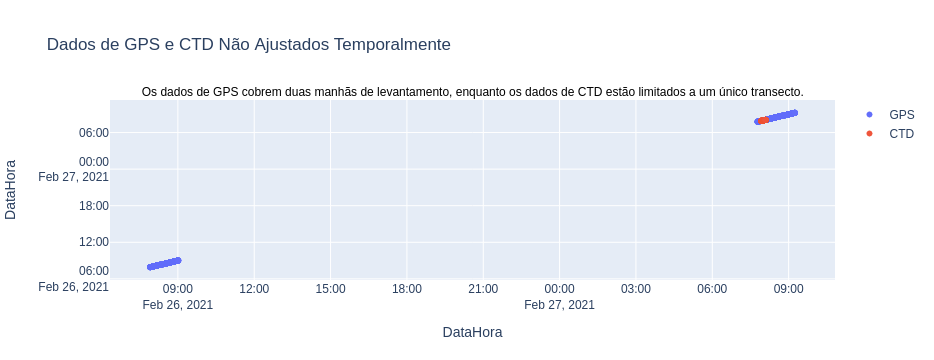

In [11]:
# Criar as traces para os dados de GPS e CTD
trace_ctd = go.Scatter(x=CTD_df['tempo'], y=CTD_df['tempo'], mode='markers', name='CTD')
trace_gps = go.Scatter(x=GPS_df['tempo'], y=GPS_df['tempo'], mode='markers', name='GPS')

# Criar o layout do gráfico
layout = go.Layout(title='Dados de GPS e CTD Não Ajustados Temporalmente', xaxis=dict(title='DataHora'), yaxis=dict(title='DataHora'),
                   annotations=[
                       dict(
                           x=0.5,
                           y=1.1,
                           xref='paper',
                           yref='paper',
                           text='Os dados de GPS cobrem duas manhãs de levantamento, enquanto os dados de CTD estão limitados a um único transecto.',
                           showarrow=False,
                           font=dict(
                               size=12,
                               color='black'
                           )
                       )
                   ])


# Criar a figura que será exibida
fig = go.Figure(data=[trace_gps, trace_ctd], layout=layout)

# Exibir o gráfico
fig.show()

In [12]:
# Copiar o DataFrame CTD_df para ctd_df
ctd_df = CTD_df.copy()

# Definir a coluna 'tempo' como o índice do DataFrame
ctd_df.set_index('tempo', inplace=True)

# Inicializar variáveis
primeira_ocorrencia = None  # Variável para armazenar a primeira ocorrência de um índice
n_ocorrencias = []       # Lista para armazenar o número de ocorrências para cada índice
c = 0                    # Contador de ocorrências

# Iterar sobre os índices do DataFrame
for idx in ctd_df.index:
    # Verificar se é a primeira ocorrência do índice ou se é diferente da primeira ocorrência anterior
    if primeira_ocorrencia is None or idx != primeira_ocorrencia:
        n_ocorrencias.append(c)  # Adicionar o número de ocorrências do índice anterior à lista
        primeira_ocorrencia = idx   # Atualizar a primeira ocorrência com o índice atual
        c = 1                    # Resetar o contador de ocorrências para 1
    else:
        c += 1  # Incrementar o contador de ocorrências se o índice for igual à primeira ocorrência anterior

# Adicionar o número de ocorrências da última entrada à lista
n_ocorrencias.append(c)

# Remover a primeira ocorrência (que é o número de ocorrências do primeiro índice)
n = n_ocorrencias[1:]

# Adicionar 10 (número de itens por minuto) ao fim da lista senão iria faltar
n.append(10)


In [13]:
n_indice = []  # Lista para armazenar os novos índices

# Iterar sobre os índices únicos do DataFrame
for i, u in enumerate(ctd_df.index.unique()):
    # Verificar se o número de ocorrências é 10
    if n[i] == 10:
        t_increment = pd.Timedelta(0)  # Se sim, definir o incremento de tempo como 0
    else:
        # Se não, calcular o incremento de tempo baseado no número de ocorrências
        t_increment = pd.Timedelta(100000000 * (n[i]))
    
    # Iterar sobre o número de ocorrências para o índice atual
    for j in range(n[i]):
        # Adicionar o índice ajustado com o incremento de tempo à lista n_indice
        n_indice.append(u + t_increment)
        
        # Atualizar o incremento de tempo para a próxima ocorrência com um pequeno incremento
        t_increment += pd.Timedelta(milliseconds=100)


In [14]:
# Converter a lista de timestamps em um objeto pandas Datetime
datetime_indice = pd.to_datetime(n_indice)

# Atribuir os novos índices ao DataFrame
ctd_df.index = pd.Index(datetime_indice, name='tempo')
# Reseta o índice, voltando para série númerica
ctd_df.reset_index(inplace=True)

In [15]:
# Cria uma cópia do DataFrame GPS_df
gps_df = GPS_df.copy()

# Primeiro, garanta que ambos os DataFrames tenham índices do tipo datetime
gps_df.set_index('tempo', inplace=True)
ctd_df.set_index('tempo', inplace=True)

# Reamostra o DataFrame para 10Hz (a cada 0.1 segundos)
gps_df_resampled = gps_df.resample('0.1S').asfreq()

# Garante que as colunas do tipo objeto sejam convertidas para os tipos apropriados
gps_df_resampled = gps_df_resampled.infer_objects(copy=False)

# Interpola o DataFrame reamostrado
gps_df_interp = gps_df_resampled.interpolate(method='linear')

# Obtém as datas e horas de início e fim de ctd_df
start_datetime = ctd_df.index.min()
end_datetime = ctd_df.index.max()

# Corta o DataFrame gps_df para iniciar e terminar nas mesmas datas e horas que ctd_df
gps_df_sliced = gps_df_interp.loc[start_datetime:end_datetime]

# Resetar o índice
gps_df_sliced.reset_index(inplace=True)
ctd_df.reset_index(inplace=True)


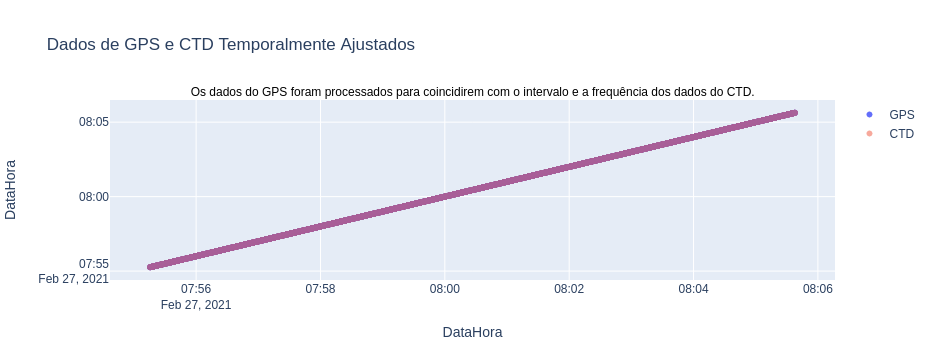

In [16]:
# Criar as traces para os dados de GPS e CTD
trace_gps = go.Scatter(x=gps_df_sliced['tempo'], y=gps_df_sliced['tempo'], mode='markers', name='GPS')  # Trace para os dados de GPS
trace_ctd = go.Scatter(x=ctd_df['tempo'], y=ctd_df['tempo'], mode='markers', name='CTD', opacity=0.5)  # Trace para os dados de CTD

# Criar o layout do gráfico
layout = go.Layout(title='Dados de GPS e CTD Temporalmente Ajustados',  # Título do gráfico
                   xaxis=dict(title='DataHora'),  # Título do eixo x
                   yaxis=dict(title='DataHora'),  # Título do eixo y
                   annotations=[  # Adiciona anotações ao gráfico
                       dict(
                           x=0.5,
                           y=1.1,
                           xref='paper',
                           yref='paper',
                           text='Os dados do GPS foram processados para coincidirem com o intervalo e a frequência dos dados do CTD.',  # Texto da anotação
                           showarrow=False,
                           font=dict(
                               size=12,
                               color='black'
                           )
                       )
                   ])

# Criar a figura que será exibida
fig = go.Figure(data=[trace_gps, trace_ctd], layout=layout)

# Exibir o gráfico
fig.show()


In [17]:
# Mesclar os DataFrames com base na coluna de tempo
dados_df = pd.merge(ctd_df, gps_df_sliced, on='tempo')

# Etibir o DataFrame mesclado
print('Dados de CTD e GPS unificados:')
display(dados_df.head())

Dados de CTD e GPS unificados:


tempo  pressao  temperatura  salinidade  \
0 2021-02-27 07:55:15.500000-03:00   -1.245       24.985       0.015   
1 2021-02-27 07:55:15.600000-03:00   -1.245       24.990       0.015   
2 2021-02-27 07:55:15.700000-03:00   -1.245       24.990       0.015   
3 2021-02-27 07:55:15.800000-03:00   -1.245       24.989       0.015   
4 2021-02-27 07:55:15.900000-03:00   -1.245       24.984       0.015   

   turbidez        lat        lon  
0      1.57 -32.135247 -52.094524  
1      1.46 -32.135246 -52.094525  
2      2.37 -32.135246 -52.094525  
3      3.13 -32.135246 -52.094526  
4      3.08 -32.135246 -52.094526

In [18]:
del CTD_df, GPS_df, gps_df, ctd_df, c, datetime_indice, end_datetime, primeira_ocorrencia, gps_df_interp, gps_df_resampled, gps_df_sliced, i, j
del n, n_indice, n_ocorrencias, start_datetime, t_increment, trace_ctd, trace_gps, u

In [19]:
# Criar um gráfico de dispersão sobre um mapa usando o Plotly Express
fig = px.scatter_mapbox(dados_df,  # DataFrame contendo os dados
                        lat="lat",  # Coluna com os valores de latitude
                        lon="lon",  # Coluna com os valores de longitude
                        hover_name='tempo',  # Informação a ser exibida ao passar o mouse sobre os pontos
                        zoom=14,  # Nível de zoom inicial do mapa
                        height=300)  # Altura do gráfico

# Atualizar o layout do gráfico
fig.update_layout(mapbox_style="open-street-map",  # Estilo do mapa (OpenStreetMap neste caso)
                  margin={"r":20,"t":30,"l":20,"b":20},  # Margens ao redor do gráfico
                  title="Dados de GPS e CTD Concatenados")  # Título do gráfico

# Exibir o gráfico
fig.show()


### Calculando a profundidade a partir da pressão e da latitude média

In [20]:
# Inserir uma nova coluna chamada 'profundidade' no índice 2 do DataFrame 'dados_df'
# A profundidade é calculada usando a função sw.eos80.dpth(), que leva em consideração a pressão e a latitude média
# A multiplicação por -1 é usada para inverter o sinal e obter a negativa
# Na prática não é profundidade, pois foi não foi realizada redução pela maré. Sendo assim, o mais correto é metro abaixo da superfície,
# em inglés, meters below surface (mbs)
dados_df.insert(2, 'profundidade', (sw.eos80.dpth(dados_df.pressao, dados_df.lat.mean()) * -1))


### Retirada dos dados do 'topo' (menos de 0.5 metros abaixo da superfície)

In [21]:
# Filtrar as linhas com profundidade maior ou igual a meio metro, descartando as restantes
dados_df_st = dados_df[dados_df['profundidade'] < -0.5]

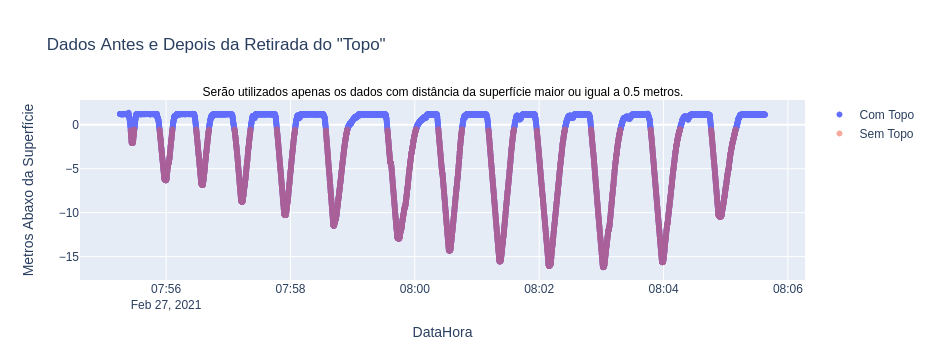

In [22]:
# Criar as traces para os dados com e sem 'topo'
trace_ctopo = go.Scatter(x=dados_df['tempo'], y=dados_df['profundidade'], mode='markers', name='Com Topo')
trace_stopo = go.Scatter(x=dados_df_st['tempo'], y=dados_df_st['profundidade'], mode='markers', name='Sem Topo', opacity=0.5)

# Criar o layout do gráfico
layout = go.Layout(title='Dados Antes e Depois da Retirada do "Topo"', xaxis=dict(title='DataHora'), yaxis=dict(title='Metros Abaxo da Superfície'),
                   annotations=[
                       dict(
                           x=0.5,
                           y=1.1,
                           xref='paper',
                           yref='paper',
                           text='Serão utilizados apenas os dados com distância da superfície maior ou igual a 0.5 metros.',
                           showarrow=False,
                           font=dict(
                               size=12,
                               color='black'
                           )
                       )
                   ])

# Criar a figura que será exibida
fig = go.Figure(data=[trace_ctopo, trace_stopo], layout=layout)

# Exibir o gráfico
fig.show()

In [23]:
del idx

### Separar as subidas das descidas

In [24]:
def encontrar_pontos_inflexao(dados):
    """
    Encontra os pontos de inflexão nos dados.
    
    Args:
        dados (DataFrame): DataFrame contendo os dados do CTD.
        
    Returns:
        list: Lista de índices dos pontos de inflexão.
    """
    # Inicializa a lista de índices de perfis com o primeiro índice
    indice_perfis = [0]
    
    # Itera sobre os dados para encontrar os pontos de inflexão
    for i in range(len(dados) - 1):
        if (dados.iloc[i, 3] - dados.iloc[i + 1, 3]) > 1:
            # Se a diferença entre os valores de profundidade for maior que 1,
            # considera-se um ponto de inflexão
            indice_perfis.append(i)
            indice_perfis.append(i + 1)
    
    # Adiciona o último índice
    indice_perfis.append(len(dados) - 1)
    
    return indice_perfis

def separar_perfis(dados, inicio_perfis, final_perfis):
    """
    Separa os perfis com base nos índices de início e fim dos perfis.
    
    Args:
        dados (DataFrame): DataFrame contendo os dados do CTD.
        inicio_perfis (list): Lista de índices de início dos perfis.
        final_perfis (list): Lista de índices de fim dos perfis.
        
    Returns:
        DataFrame: DataFrame contendo os perfis separados.
    """
    # Separa os perfis com base nos índices
    perfis_separados = [dados.iloc[inicio:final] for inicio, final in zip(inicio_perfis, final_perfis) if dados.iloc[inicio:final, 4].max() > (dados.iloc[inicio:final, 4].min() + 0.5)]
    
    # Concatena os perfis separados em um único DataFrame
    return pd.concat(perfis_separados)

def identificar_descida_subida(dados):
    """
    Identifica os dados de descida e subida nos perfis.
    
    Args:
        dados (DataFrame): DataFrame contendo os perfis.
        
    Returns:
        DataFrame: DataFrame contendo os dados de descida.
        DataFrame: DataFrame contendo os dados de subida.
    """
    # Identifica os dados de descida
    perfis_subida = dados[dados['profundidade'].diff() > 0.03] # esse valor controla a tolerância 
    
    # Identifica os dados de subida
    perfis_descida = dados[dados['profundidade'].diff() < -0.08] # esse valor controla a tolerância
    
    return perfis_descida, perfis_subida


In [25]:
# Encontrar pontos de inflexão
indice_perfis = encontrar_pontos_inflexao(dados_df_st)

# Separar perfis
inicio_perfis = indice_perfis[::2]
final_perfis = indice_perfis[1::2]
perfis_separados = separar_perfis(dados_df_st, inicio_perfis, final_perfis)

# Identificar dados de descida e subida
perfis_descida, perfis_subida = identificar_descida_subida(perfis_separados)

In [26]:
del encontrar_pontos_inflexao, final_perfis, inicio_perfis, indice_perfis, dados_df, perfis_separados
del trace_ctopo, trace_stopo, separar_perfis

### Visualizando os dados separados

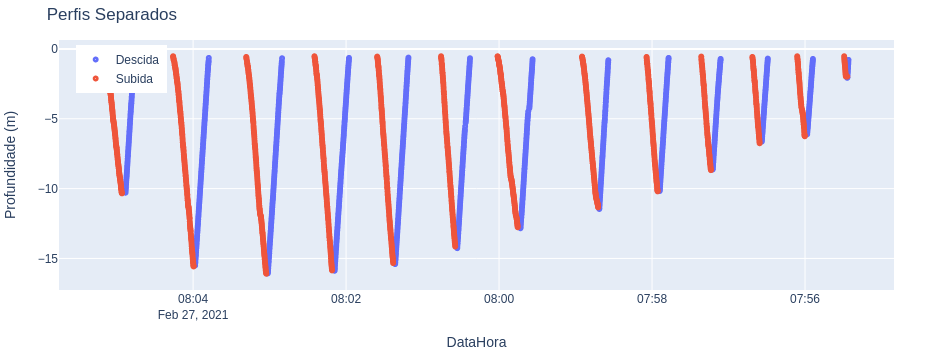

In [27]:
# Plotar os dados de descida
trace_descida = go.Scatter(x=perfis_descida['tempo'], y=perfis_descida['profundidade'],
                           mode='markers', name='Descida', marker=dict(symbol='circle-dot'))

# Plotar os dados de subida
trace_subida = go.Scatter(x=perfis_subida['tempo'], y=perfis_subida['profundidade'],
                          mode='markers', name='Subida', marker=dict(symbol='circle-dot'))

# Layout do gráfico
layout = go.Layout(title='Perfis Separados',
                   xaxis=dict(title='DataHora'),
                   yaxis=dict(title='Profundidade (m)'),
                   legend=dict(x=0.02, y=0.98),
                   margin=dict(l=40, r=40, t=40, b=40))

# Criar figura
fig = go.Figure(data=[trace_descida, trace_subida], layout=layout)

# Inverter eixo x
fig.update_xaxes(autorange="reversed")

# Exibir o gráfico
pio.show(fig)

In [28]:
del trace_subida, trace_descida, identificar_descida_subida

### Visualizando os perfis de descida

In [29]:
fig = px.scatter_mapbox(perfis_descida, lat="lat", lon="lon", hover_name='tempo', zoom=14, height=300)
fig.update_layout(mapbox_style="open-street-map",
                 margin={"r":20,"t":30,"l":20,"b":20},
                 title='Coordenadas dos Perfis Verticais de Descida')
fig.update_layout()
fig.show()

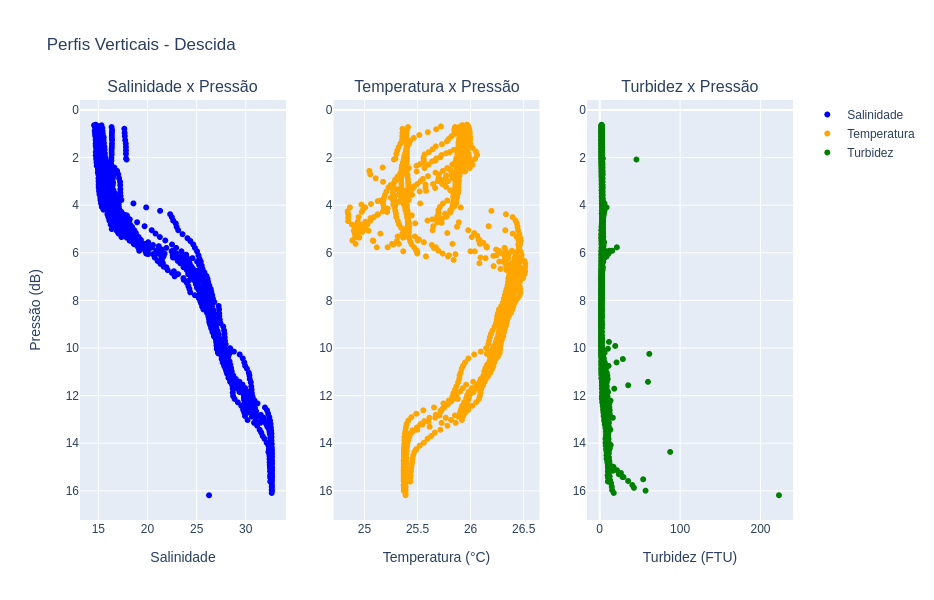

In [30]:
# Criar subplots
fig = make_subplots(rows=1, cols=3, shared_yaxes=True, subplot_titles=('Salinidade x Pressão', 'Temperatura x Pressão', 'Turbidez x Pressão'))

# Adicionar perfil de salinidade x pressão
fig.add_trace(go.Scatter(x=perfis_descida['salinidade'], y=perfis_descida['pressao'], mode='markers', name='Salinidade',
                         marker=dict(color='blue')), row=1, col=1)
fig.update_xaxes(title_text="Salinidade", row=1, col=1)
fig.update_yaxes(title_text="Pressão (dB)", autorange="reversed", row=1, col=1)

# Adicionar perfil de temperatura x pressão
fig.add_trace(go.Scatter(x=perfis_descida['temperatura'], y=perfis_descida['pressao'], mode='markers', name='Temperatura',
                         marker=dict(color='orange')), row=1, col=2)
fig.update_xaxes(title_text="Temperatura (°C)", row=1, col=2)
fig.update_yaxes(autorange="reversed", showticklabels=True, row=1, col=2)

# Adicionar perfil de turbidez x pressão
fig.add_trace(go.Scatter(x=perfis_descida['turbidez'], y=perfis_descida['pressao'], mode='markers', name='Turbidez',
                         marker=dict(color='green')), row=1, col=3)
fig.update_xaxes(title_text="Turbidez (FTU)", row=1, col=3)
fig.update_yaxes(autorange="reversed", showticklabels=True, row=1, col=3)

# Atualizar layout do gráfico
fig.update_layout(height=600,autosize=True, title_text="Perfis Verticais - Descida")

# Mostrar o gráfico
fig.show()

### Calculando as Distâncias de um Ponto Projetado Linearmente

In [31]:
def calcular_distancias(df, retornar_xy=False):
    """
    Calcula as distancias de cada ponto em relação a um ponto de referência na 'longitude'.

    Parâmetros:
    - df: DataFrame contendo as colunas 'lon' e 'lat' com dados de longitude e latitude, respectivamente.
    - retornar_xy: Booleano indicando se os arrays x e y devem ser retornados ou não (opcional, padrão é False).

    Retorna:
    - df: DataFrame com a coluna 'distancia' contendo as distancias calculadas em metros.
    - (opcional) x: Array numpy contendo os dados de longitude.
    - (opcional) y: Array numpy contendo os dados de latitude.
    """
    
    df = df.copy() # Só porque estava recebendo um aviso (warning)...

    
    # Verificar dados ausentes
    if df[['lon', 'lat']].isnull().values.any():
        raise ValueError("Dados de latitude ou longitude ausentes.")

    # Convertendo dados de latitude e longitude para arrays de float64
    x = np.array(df.lon).astype(np.float64)
    y = np.array(df.lat).astype(np.float64)

    # Latitude média como referência para o ponto projetado
    lat_ref = np.mean(y)

    # Conversão da extensão, em km, de um grau de longitude para a latitude da área de estudo
    conversao = 111.12 * np.cos(np.radians(lat_ref))

    # Realize a regressão linear para obter os coeficientes
    coeficientes = np.polyfit(x, y, 1)
    slope = coeficientes[0]   # Inclinação da reta
    intercept = coeficientes[1]   # Interceptação com o eixo y

    # Configurando um ponto de referência na 'longitude'
    xref = x.min() - 2/conversao  # Deslocamento de aprotimadamente 2 km a oeste
    yref = intercept + slope * xref  # Calculando a 'latitude' correspondente ao ponto de referência usando o modelo linear

    ponto_projetado = (xref, yref)

    # Calculando a diferença entre os dados de Longitude e Latitude em relação ao ponto de referência
    dx = x - xref
    dy = y - yref

    # Calculando a distancia euclidiana entre cada ensemble e o ponto de referência
    # em quilômetros usando a conversão específica da latitude média dos dados
    distancia_km = (dx**2 + dy**2)**.5 * conversao

    # Ajustando a distancia para que seja em relação ao primeiro ensemble 
    # E convertendo para metros
    distancia = (distancia_km - np.min(distancia_km)) * 1000

    # Adicionando ao dataframe usando .loc para evitar o aviso
    df.loc[:, 'distancia'] = distancia

    if retornar_xy:
        return df, x, y
    else:
        return df

## Exemplo de uso:
# df = calcular_distancias(df)
## Ou, para retornar também os arrays x e y:
# df, x_array, y_array = calcular_distancias(df, retornar_xy=True)

In [32]:
# Aplica a função
descida_df, x_array, y_array = calcular_distancias(perfis_descida, retornar_xy=True)

In [33]:
# Realize a regressão linear para obter os coeficientes
coeficientes = np.polyfit(x_array, y_array, 1)

# Cria a função polinomial com base nos coeficientes da regressão linear
funcao_regressao = np.poly1d(coeficientes)

# Cria uma linha representando a reta de regressão
# E estende a reta de regressão além dos pontos etistentes
x_ext = np.linspace(min(x_array)-0.05, max(x_array)+0.05, 100)  # 100 pontos para a extensão
y_ext = funcao_regressao(x_ext)
reta_regressao = LineString(list(zip(x_ext, y_ext)))

# Crie um GeoDataFrame para armazenar as geometrias
geometry = [Point(lon, lat) for lat, lon in zip(y_array, x_array)]
gdf = gpd.GeoDataFrame(geometry=geometry)

# Latitude média como referência para o ponto projetado
lat_ref = np.mean(y_array)

# Conversão da extensão, em km, de um grau de longitude para a latitude da área de estudo
# 111.12 km é a extensão de um grau de longitude no equador (40000km / 360graus)
conversao = 111.12 * np.cos(np.radians(lat_ref))

# Configurando um ponto de referência na 'longitude'
xref = x_array.min() - 2/conversao  # Deslocamento de aprotimadamente 2 km a oeste
slope = coeficientes[0]   # Inclinação da reta
intercept = coeficientes[1]   # Interceptação com o eixo y
yref = intercept + slope * xref  # Calculando a 'latitude' correspondente ao ponto de referência usando o modelo linear

ponto_projetado = (xref, yref)

# Crie um GeoDataFrame para o ponto projetado
gdf_ponto = gpd.GeoDataFrame(geometry=[Point(ponto_projetado)])

# Crie um GeoDataFrame para a linha de regressão
gdf_linha = gpd.GeoDataFrame(geometry=[reta_regressao])

In [34]:
del calcular_distancias, coeficientes, conversao, geometry, intercept, lat_ref, x_ext, y_ext, yref, xref
del funcao_regressao, ponto_projetado, reta_regressao, perfis_subida, perfis_descida

### Visualizando a Reta de Regressão e o Ponto no Mapa

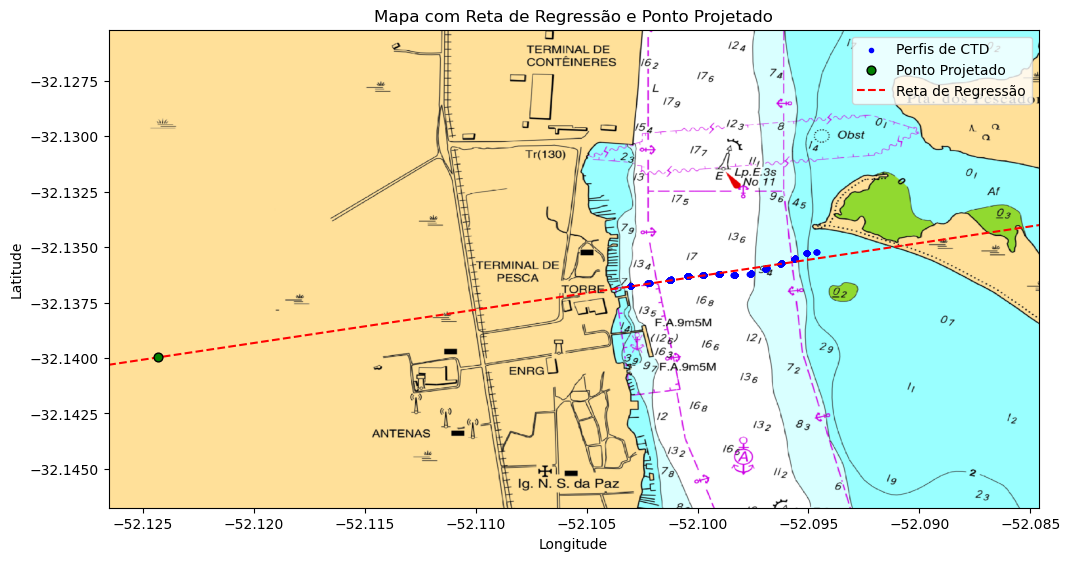

In [35]:
basemap = rasterio.open(basemap_path)  # Abrindo o arquivo de mapa base com rasterio

# Plote a nuvem de pontos, a reta de regressão e o ponto projetado
fig, ax = plt.subplots(figsize=(12, 8))
gdf.plot(ax=ax, marker='.', color='blue', label='Perfis de CTD')
gdf_ponto.plot(ax=ax, marker='o', color='g', label='Ponto Projetado', zorder=3, markersize=40, edgecolors='black')
gdf_linha.plot(ax=ax, color='red', linestyle='--', label='Reta de Regressão')

# Adiciona rótulos e legendas
plt.title('Mapa com Reta de Regressão e Ponto Projetado')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

# Dê um zoom out ajustando os limites do gráfico
ax.set_xlim(min(x_array)-0.0235, max(x_array)+0.01)
ax.set_ylim(min(y_array)-0.01, max(y_array)+0.01)

# Mostre o basemap
show(basemap, ax=ax, cmap='Blues')

# Etiba o mapa
plt.show()

In [36]:
del basemap, basemap_path, gdf, gdf_linha, gdf_ponto, slope, x_array, y_array

### Identificando Outliers Graficamente

In [37]:
## Perfis Verticais de Salinidade
# fig, ax = plt.subplots(figsize=(25, 10), dpi=300)
# scatter = ax.scatter(descida_df['distancia'], descida_df['profundidade'], c=descida_df['salinidade'], cmap='jet')

# plt.title('Salinidade - orientação oeste > leste')
# plt.colorbar(scatter, label='Salinidade')

# ax.set_xlabel('distancia (m)')
# ax.set_ylabel('Profundidade (m)')

# plt.rcParams.update({'font.size': 18})  # Ajuste o tamanho da fonte conforme necessário

# plt.show()


In [38]:
# Definir a função de plotagem interativa
def plot_histogram(columns, bin_size, cutoff_value):
    fig = go.Figure()
    for column in columns:
        # Criar uma cópia do valor de cutoff_value para esta coluna
        cutoff_value_col = np.clip(cutoff_value, descida_df[column].min(), descida_df[column].max())
        filtered_df = descida_df[descida_df[column] < cutoff_value_col]

        # Adicionar o histograma ao gráfico
        fig.add_trace(go.Histogram(x=filtered_df[column], nbinsx=bin_size, name=column.capitalize()))

    # Atualizar layout e mostrar o gráfico
    fig.update_layout(title='Histograma dos Parâmetros:',
                      xaxis_title='Valor',
                      yaxis_title='Ocorrência',
                      margin=dict(l=40, r=40, t=40, b=40),
                      height=400)
    fig.show()

# Texto informativo
info_text = widgets.HTML(value="<p>Selecione o(s) parâmetro(s) que deseja visualizar no histograma. Mais de uma coluna pode ser visualizada simultaneamente. Para selecionar múltiplas colunas, mantenha pressionada a tecla 'Ctrl' (ou 'Command' no Mac) enquanto clica nas opções disponíveis.</p>")

# Definir os controles deslizantes interativos
bin_slider = widgets.IntSlider(value=90, min=1, max=100, step=1, description='Bins:', layout=widgets.Layout(width='90%'))
cutoff_slider = widgets.FloatSlider(value=descida_df['turbidez'].max(), min=descida_df['turbidez'].min(), max=descida_df['turbidez'].max(), step=0.1, description='Corte:', layout=widgets.Layout(width='90%'))
column_dropdown = widgets.SelectMultiple(options=['salinidade', 'temperatura', 'turbidez'], 
                                         value=['salinidade'], 
                                         description='Parâmetros:',
                                         layout=widgets.Layout(width='25%', 
                                                               height='73px'))

# Layout da caixa
box_layout = widgets.Layout(display='flex',
                            flex_flow='row',
                            width='90%')

# Adicionar os widgets à caixa
box = widgets.Box(children=[info_text], layout=box_layout)

# Exibir a caixa
display(box)

# Conectar os controles deslizantes à função de plotagem
widgets.interact(plot_histogram, columns=column_dropdown, bin_size=bin_slider, cutoff_value=cutoff_slider);




Box(children=(HTML(value="<p>Selecione o(s) parâmetro(s) que deseja visualizar no histograma. Mais de uma colu…

interactive(children=(SelectMultiple(description='Parâmetros:', index=(0,), layout=Layout(height='73px', width…

### Retirando Outliers

In [39]:
descida_filt_df = descida_df.copy()

In [40]:
# Função para filtrar o DataFrame com base no valor de referência e na coluna selecionada
def filtrar_dataframe(coluna, valor_referencia):
    global descida_filt_df  # Utiliza a variável global descida_filt_df
    descida_filt_df = descida_filt_df[descida_filt_df[coluna] < valor_referencia]  # Filtra o DataFrame com base na coluna e valor de referência
    with out:
        clear_output()  # Limpa a saída anterior
        print("DataFrame filtrado com sucesso!")  # Mensagem indicando sucesso na filtragem
        print("Os 10 maiores valores da coluna selecionada após filtragem:")  # Mensagem informativa
        print(descida_filt_df[coluna].nlargest(10))  # Exibe os 10 maiores valores da coluna após filtragem

# Widgets
texto_informativo = widgets.HTML(value="<b>Este controle interativo permite que você defina um valor de referência (Corte) para filtrar um DataFrame. Selecione a coluna desejada e insira o valor de referência." 
                                 "Os valores nas linhas correspondentes à coluna selecionada que forem menores ou iguais ao valor de referência serão mantidos, enquanto os valores maiores" 
                                 "serão removidos em todas as colunas correspondentes.</b>")  # Texto informativo

coluna_dropdown = widgets.Dropdown(
    options=['turbidez', 'salinidade', 'temperatura'],
    value='turbidez',
    description='Coluna:'  # Dropdown para seleção da coluna
)

valor_referencia_widget = widgets.IntText(
    value=150,
    description='Valor de Referência:'  # Widget de entrada para o valor de referência
)

botao_filtrar = widgets.Button(description='Filtrar', button_style='danger')  # Botão para acionar a filtragem
out = widgets.Output()  # Saída para exibir mensagens de sucesso e os 10 maiores valores após a filtragem

# Função de callback do botão
def on_botao_filtrar_clicked(b):
    filtrar_dataframe(coluna_dropdown.value, valor_referencia_widget.value)  # Chama a função de filtragem com os valores selecionados

botao_filtrar.on_click(on_botao_filtrar_clicked)  # Atribui a função de callback ao botão de filtragem

# Exibição dos widgets
display(texto_informativo)  # Exibe o texto informativo
display(coluna_dropdown)     # Exibe o dropdown para seleção da coluna
display(valor_referencia_widget)  # Exibe o widget para entrada do valor de referência
display(botao_filtrar)       # Exibe o botão para acionar a filtragem
display(out)                 # Exibe a saída para mensagens e resultados da filtragem


HTML(value='<b>Este controle interativo permite que você defina um valor de referência (Corte) para filtrar um…

Dropdown(description='Coluna:', options=('turbidez', 'salinidade', 'temperatura'), value='turbidez')

IntText(value=150, description='Valor de Referência:')

Button(button_style='danger', description='Filtrar', style=ButtonStyle())

Output()

In [41]:
# Definir a função de plotagem interativa
def plot_histogram(columns, bin_size, cutoff_value):
    fig = go.Figure()
    for column in columns:
        # Criar uma cópia do valor de cutoff_value para esta coluna
        cutoff_value_col = np.clip(cutoff_value, descida_filt_df[column].min(), descida_filt_df[column].max())
        filtered_df = descida_filt_df[descida_filt_df[column] < cutoff_value_col]

        # Adicionar o histograma ao gráfico
        fig.add_trace(go.Histogram(x=filtered_df[column], nbinsx=bin_size, name=column.capitalize()))

    # Atualizar layout e mostrar o gráfico
    fig.update_layout(title='Histograma dos Parâmetros:  Avalie a Retirada dos Outliers',
                      xaxis_title='Valor',
                      yaxis_title='Ocorrência',
                      margin=dict(l=40, r=40, t=40, b=40),
                      height=400)
    fig.show()

# Texto informativo
info_text = widgets.HTML(value="<p>Selecione o(s) parâmetro(s) que deseja visualizar no histograma. Mais de uma coluna pode ser visualizada simultaneamente. Para selecionar múltiplas colunas, mantenha pressionada a tecla 'Ctrl' (ou 'Command' no Mac) enquanto clica nas opções disponíveis.</p>")

# Definir os controles deslizantes interativos
bin_slider = widgets.IntSlider(value=90, min=1, max=100, step=1, description='Bins:', layout=widgets.Layout(width='90%'))
cutoff_slider = widgets.FloatSlider(value=30, min=descida_filt_df['turbidez'].min(), max=descida_filt_df['turbidez'].max(), step=0.1, description='Corte:', layout=widgets.Layout(width='90%'))
column_dropdown = widgets.SelectMultiple(options=['salinidade', 'temperatura', 'turbidez'], 
                                         value=['salinidade'], 
                                         description='Parâmetros:',
                                         layout=widgets.Layout(width='25%', 
                                                               height='73px'))

# Layout da caixa
box_layout = widgets.Layout(display='flex',
                            flex_flow='row',
                            width='90%')

# Adicionar os widgets à caixa
box = widgets.Box(children=[info_text], layout=box_layout)

# Exibir a caixa
display(box)

# Conectar os controles deslizantes à função de plotagem
widgets.interact(plot_histogram, columns=column_dropdown, bin_size=bin_slider, cutoff_value=cutoff_slider);

Box(children=(HTML(value="<p>Selecione o(s) parâmetro(s) que deseja visualizar no histograma. Mais de uma colu…

interactive(children=(SelectMultiple(description='Parâmetros:', index=(0,), layout=Layout(height='73px', width…

In [42]:
del bin_slider, box, box_layout, column_dropdown, coluna_dropdown, cutoff_slider, descida_df, filtrar_dataframe
del on_botao_filtrar_clicked, plot_histogram, texto_informativo, valor_referencia_widget

### Gráfico de Dispersão Perfis de Descida

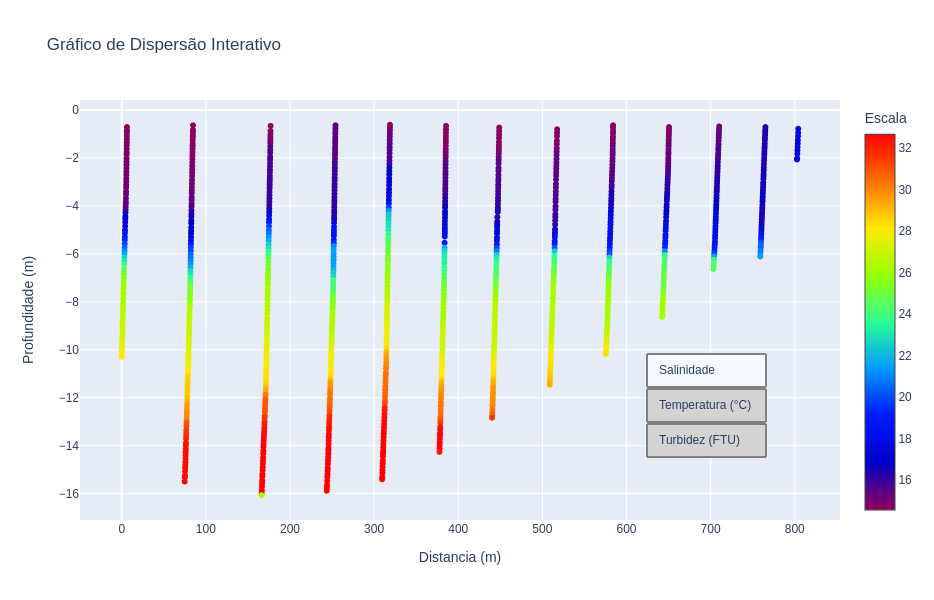

In [43]:
# Dados iniciais
dados_x = descida_filt_df['distancia']
dados_y = descida_filt_df['profundidade']
dados_z = descida_filt_df['salinidade']  # Começa com salinidade como cor padrão

# Criar a figura inicial
fig = go.Figure(data=go.Scatter(x=dados_x, y=dados_y, mode='markers',
                                marker=dict(color=dados_z, colorscale='Rainbow', colorbar=dict(title='Escala')),
                                text=['Salinidade: {:.2f}<br>Temperatura: {:.2f}<br>Turbidez: {:.2f}'.format(s, t, u) 
                                      for s, t, u in zip(descida_filt_df['salinidade'], descida_filt_df['temperatura'], descida_filt_df['turbidez'])]))


# Definir botões para alternar entre as variáveis de cor
buttons = []
for nome, dados_cor in [('Salinidade', descida_filt_df['salinidade']),
                        ('Temperatura (°C)', descida_filt_df['temperatura']),
                        ('Turbidez (FTU)', descida_filt_df['turbidez'])]:
    botao = dict(label=nome,
                  method="update",
                  args=[{"marker.color": [dados_cor]},
                        {"marker.colorbar.title.text": nome}])
    buttons.append(botao)

# Adicionar botões para alternar as variáveis de cor
fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="down",
            buttons=buttons,
            x=0.9,
            xanchor='right',
            y=0.4,
            yanchor='top',
            # Destacar o botão selecionado
            showactive=True,
            bgcolor='lightgrey',  # Cor de fundo para o botão selecionado
            bordercolor='grey',   # Cor do contorno do botão selecionado
            borderwidth=2         # Largura do contorno do botão selecionado
        )
    ]
)



fig.update_xaxes(showspikes=True, spikecolor="black", spikethickness=2)
fig.update_yaxes(showspikes=True, spikecolor="black", spikethickness=2)

# Atualizar layout do gráfico
fig.update_layout(title='Gráfico de Dispersão Interativo',
                  xaxis_title='Distancia (m)',
                  yaxis_title='Profundidade (m)',
                  height=600,
                  autosize=True)

# Etibir o gráfico
fig.show()


### Interpolando

In [44]:
# Definir a grade para interpolação
di = np.linspace(descida_filt_df['distancia'].min(), descida_filt_df['distancia'].max(), 41)
pi = np.linspace(descida_filt_df['profundidade'].min(), descida_filt_df['profundidade'].max(), 50)
dd, pp = np.meshgrid(di, pi)


points = np.array([descida_filt_df['distancia'], descida_filt_df['profundidade']]).T
# Interpolar os dados de salinidade
sal_i = griddata(points, descida_filt_df['salinidade'], (dd, pp), method='linear', rescale=True)

# Interpolar os dados de temperatura
temp_i = griddata(points, descida_filt_df['temperatura'], (dd, pp), method='linear', rescale=True)

# Interpolar os dados de turbidez
turb_i = griddata(points, descida_filt_df['turbidez'], (dd, pp), method='linear', rescale=True)

### Visualizando dados interpolados

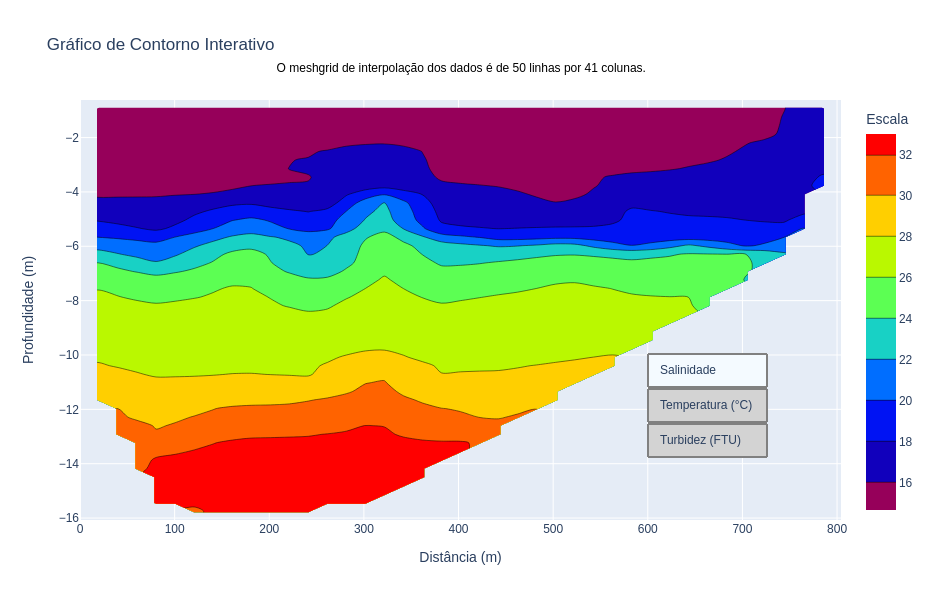

In [45]:
# Empilhar temp_i e turb_i ao longo do novo eixo (eixo 2)
customdata = np.stack((temp_i, turb_i), axis=2)

# Criar o gráfico de contorno inicial
fig = go.Figure(data=go.Contour(z=sal_i, x=di, y=pi, 
                                customdata=customdata,
                                line_smoothing=0.85,
                                colorscale='Rainbow',
                                colorbar=dict(title='Escala'),
                                hovertemplate ="Distância: %{x:.2f}m"+\
                                               "<br>Profundidade: %{y:.2f}m"+\
                                               "<br>Salinidade: %{z:.2f}"+\
                                               "<br>Temperatura: %{customdata[0]:.2f}°C"+\
                                               "<br>Turbidez: %{customdata[1]:.2f}FTU<extra></extra>"))



# Definir botões para alternar entre as variáveis de cor
buttons = [
    dict(label="Salinidade",
         method="update",
         args=[{"z": [sal_i]},
               {"colorbar.title.text": "Salinidade"}]),
    dict(label="Temperatura (°C)",
         method="update",
         args=[{"z": [temp_i]},
               {"colorbar.title.text": "Temperatura"}]),
    dict(label="Turbidez (FTU)",
         method="update",
         args=[{"z": [turb_i]},
               {"colorbar.title.text": "Turbidez"}])
]


# Adicionar botões para alternar as variáveis de cor
fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="down",
            buttons=buttons,
            x=.9,
            xanchor='right',
            y=.4,
            yanchor='top',
            
            # Destacar o botão selecionado
            showactive=True,
            bgcolor='lightgrey',  # Cor de fundo para o botão selecionado
            bordercolor='grey',   # Cor do contorno do botão selecionado
            borderwidth=2         # Largura do contorno do botão selecionado
        )
    ]
)


# Atualizar layout do gráfico
fig.update_layout(title='Gráfico de Contorno Interativo',
                  xaxis_title='Distância (m)',
                  yaxis_title='Profundidade (m)',
                  height=600, autosize=True,
                   annotations=[
                       dict(
                           x=0.5,
                           y=1.1,
                           xref='paper',
                           yref='paper',
                           text='O meshgrid de interpolação dos dados é de 50 linhas por 41 colunas.',
                           showarrow=False,
                           font=dict(
                               size=12,
                               color='black'
                           )
                       )
                   ])




fig.update_xaxes(showspikes=True, spikecolor="black", spikethickness=2)
fig.update_yaxes(showspikes=True, spikecolor="black", spikethickness=2)

# Etibir o gráfico
fig.show()


In [46]:
del buttons, botao_filtrar, dados_cor, dados_x, dados_y, dados_z